In [1]:
import numpy as np
import matplotlib.pyplot as plt
import surface_code
import layers
import matching

# Demo 2: Surface code simulation
In this demo we will go through the simulations of the surface code under the different error models and 
see the methodology followed into calculating a threshold.

### Random error model
First lets analyze the simulations of the surface code under random error to get an idea of the code works.
The general idea when simulation the surface code is:
1. Define all the relevant parameters (code distance, error rates, topology).
2. Perform some number of measurements and introduce error on each step.
3. Feed the measured syndromes into a decoder and apply the obtained corrections.
4. Measure the logical qubits to find if the decoding failed or succeed.

The code is organized in a object oriented scheme, to see the functions to be used take a look into the files **surface_code.py, layers.py** and **matching.py**.

Below is an example on how simulations can be made: 

LOGICAL QUBITS:  ([1.0], [1.0])


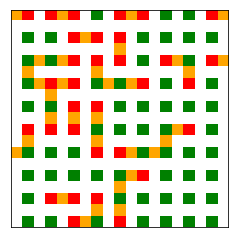

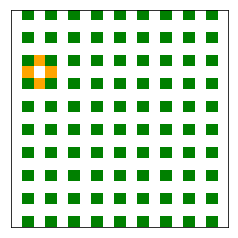

In [5]:
# Define the parameters for the surface code
distance = 10
topology = "planar"

# Initialize objects
sc = surface_code.SurfaceCode(distance, topology)
lc = layers.Layers(sc)

# Error rates 
p = 0.022 # Quit error rate
q = 0.022 # Measurement error rate
 
# Number of stabilizer measurements 
cycles = 10

# Take measurements and apply errors
for t in range(cycles):
    sc.apply_qubit_error(p, 0)
    sc.measure_all_stabilizers()
    sc._stabilizer_lie("S", q)
    lc.add()
# Final perfect last measurement
sc.measure_all_stabilizers()
lc.add()

# Plot of the errors on the surface code
# We only plot the stars since erros is only deplahsing
sc.plot("star")

# Decode and apply corrections
lc.decode()
    
# Sanity check for errors in decoding and correcting
sc.measure_all_stabilizers()
if (sc.qubits[:, sc.tags != "Q"] == -1).any():
    print("FAILURE CORRECTING")

# Plot the corrected code
sc.plot("star")
    
# Measure logical qubit
logical = sc.measure_logical()

# Check if a logical error happens
print("LOGICAL QUBITS: ", logical)
if -1 in logical[0] or -1 in logical[1]:
   print("LOGICAL QUBIT ERROR")

    
plt.show()

# Reset the surface code and erase all the stored measurements
lc.reset()
sc.reset()

### Noisy stabilizer measurements
Now lets use noisy stabilizers and environmental noise to introduce the errors.

See **Demo 1** for details on how to extract a error model for performing noisy stabilizers.
To include the error models in the simulations here we need to load the specific dictionary for the parameters given. 

In code this is achieved by calling the method **sc.init_error_obj(parameters...)**.
Below we show an example with some pre-prepared error models:

In [8]:
# Set parameters
# Gate and measurement error rates
ps = 0.003
pm = 0.003
pg = 0.003

# Very optimistic enviromental error rate and entanglement generation rate
a0 = 1.0
a1 = 1/80.
eta = 1/100.

# Theta to optimize entanglement generation
theta = .24

# Parameters for the surface code
distance = 10
topology = "toric"

# Initialize objects
sc = surface_code.SurfaceCode(distance, topology)
lc = layers.Layers(sc)

# Error object inside the surface code object handles loading the error model and 
# drawing random errors
sc.init_error_obj(topology, ps, pm, pg, eta, a0, a1, theta, "DEMO")



Don't forget that we also need to include the value of the memory error and select a stabilizer protocol for making the measurements. 

The stabilizer protocol depends on how many data qubits per node are being considered, the following image shows some of the protocols we intend to simulate:
<img src="decomposition/extras/stab_protocols.png",width=900>

In [10]:
# The average time it took to generate the GHZ state for all values of a0
# This number is obtained when creating the GHZ states
t = 0.07527

# Select protocol
sc.select_measurement_protocol(t, a1, "single")

# The error rate due to the enviroment
print("Environment error rate: ", sc.p_env)

Environment error rate:  0.00023510812897553635


We can now repeat the simulation procedure but using the new errors and the selected protocol.

LOGICAL QUBITS:  ([1.0, 1.0], [1.0, 1.0])


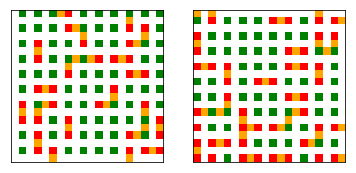

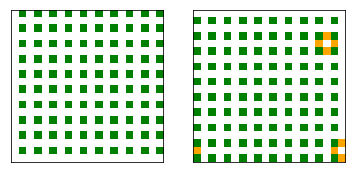

In [12]:
cycles = 10

# Take measurements and apply errors
for t in range(cycles):
    # Call choosen measurement protocol
    sc.noisy_measurement_cycle()
    lc.add()
# Final perfect last measurement
sc.measure_all_stabilizers()
lc.add()

# Plot of the errors on the surface code
sc.plot_all()

# Decode and apply corrections
lc.decode()
    
# Sanity check for errors in decoding and correcting
sc.measure_all_stabilizers()
if (sc.qubits[:, sc.tags != "Q"] == -1).any():
    print("FAILURE CORRECTING")

# Plot the corrected code
sc.plot_all()
    
# Measure logical qubit
logical = sc.measure_logical()

# Check if a logical error happens
print("LOGICAL QUBITS: ", logical)
if -1 in logical[0] or -1 in logical[1]:
   print("LOGICAL QUBIT ERROR")

plt.show()

# Reset the surface code and erase all the stored measurements
lc.reset()
sc.reset()

### Thresholds 
Now we can calculate some thresholds. 

For this demo we will try to calculate a threshold on the environmental error parameter $a_0$.
To do so we use the pre calculated error states based on the following parameters.

* $p_s = 0.003$
* $p_m = 0.003$
* $p_g = 0.003$
* $a_1 = 1/80.$
* $\eta = 1/50.$
* $\theta =  \pi/2$

And with $a_0$ varying as $a_0 = [6.0, ~ 5.5, ~ 5.0, ~ 4.5, ~ 4.0, ~ 3.5, ~ 3.0, ~ 2.5, ~ 2.0, ~ 1.5, ~ 1.0]$.

In [14]:
# Lets wrap the surface code simulation into a function for simplicity
def simulate_surface_code(cycles, iterations):
    fail_rate = 0
    for i in range(iterations):
        for t in range(cycles):
            sc.noisy_measurement_cycle()
            lc.add()
        sc.measure_all_stabilizers()
        lc.add()

        lc.decode()

        logical = sc.measure_logical()

        # Check if a logical error happens
        if -1 in logical[0] or -1 in logical[1]:
            fail_rate += 1

        lc.reset()
        sc.reset()
    fail_rate = fail_rate/iterations
    fail_rate = fail_rate/cycles
    return 1 - fail_rate


Now we can calculate the thresholds using the sample error models.

**NOTE:** Depending on the number of iterations this may take some time. For decent statistics a number of $\approx 3\times 10^3$ is required. 


In [17]:
# Set parameters
ps = 0.003
pm = 0.003
pg = 0.003
a0 = 1.0
a1 = 1/80.
eta = 1/100.
theta = .24

# The time remained approx constant when changing a0
t = 0.07527

# Parameters for the surface code
topology = "toric"

# Change the number of iterations for each simulation
iterations = 5

distances = [6, 8, 10, 12]
threshold_var = [6.0, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0]

success_rates = []

for d in distances:
    sr = []
    # Initialize objects
    sc = surface_code.SurfaceCode(d, topology)
    lc = layers.Layers(sc)



    for a0 in threshold_var:
        # Error object inside the surface code object handles loading the error model and 
        # drawing random errors
        sc.init_error_obj(topology, ps, pm, pg, eta, a0, a1, theta, "DEMO")
        
        # Select protocol
        sc.select_measurement_protocol(t, a1, "single")

        sr += [simulate_surface_code(d, iterations)]
        
    success_rates += [sr]
    


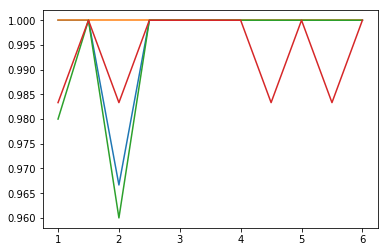

In [26]:
# Plot the resulting success rates
for p in success_rates:
    plt.plot(threshold_var, p)
    
plt.show()